# Diagnostics of FOCI-OpenIFS

In [1]:
# get the modules we need
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cmocean 
from scipy.stats import linregress

In [2]:
from dask.distributed import Client, LocalCluster, wait

In [3]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

In [4]:
client

Client Scheduler: tcp://127.0.0.1:35927 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


In [5]:
# Get the NEMO mesh (points to my personal dir, you should change to yours!)
machine = 'nesh'

if machine == 'sci':
    esmdir = '/data/user/jkjellsson/esm-experiments/focioifs/'
    nemo_mesh = '/data/user/jkjellsson/orca05_mesh_mask.nc'
elif machine == 'nesh':
    esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments/'
    esmdir2 = '/gxfs_work1/geomar/smomw352/esm-slask/'
    nemo_mesh = '/gxfs_work1/geomar/smomw352/orca05_mesh_mask.nc'

# Read NEMO grid

In [6]:
# NEMO mesh file has "z" as vertical coordinate
# but the grid_T files have "deptht" so we need to rename
ds_mesh = xr.open_dataset(nemo_mesh)
da_orca05_area = (ds_mesh['e1t'] * ds_mesh['e2t']).sel(t=0)
da_orca05_volume = (ds_mesh['e1t'] * ds_mesh['e2t'] * ds_mesh['e3t']).sel(t=0).rename({'z':'deptht'})
da_orca05_mask = ds_mesh['tmask'].sel(t=0,z=0)
da_orca05_mask_3D = ds_mesh['tmask'].sel(t=0).rename({'z':'deptht'})

## Read data

In [7]:
#exp_list = ['focioifs-merge14']
#exp_list = ['FOCI_GJK001','FOCI_NJK007','FOCI_NJK007_cont3']
#time_list = [slice('1850-01-01','3000-01-01'), slice('1850-01-01','2300-01-01'),slice('2300-01-01','3000-01-01')]

#exp_list = ['FOCI_GJK001','foci-cpl-06']
#time_list = [slice('1850-01-01','3000-01-01'),slice('1850-01-01','3150-01-01')]

#exp_list = ['foci-test-05','foci-test-07']
#time_list = [slice('1850-01-01','1960-01-01'),slice('1850-01-01','1960-01-01')]

# Old continuation that did not work
#exp_list = ['FOCI_GJK001','FOCI_GJK001_cont']
#time_list = [slice('1850-01-01','3000-01-01'),slice('3000-01-01','3200-01-01')]

# FOCI_GJK001 is the first long piControl for 1000 years
# FOCI_GJK006 continues from year 2850 of FOCI_GJK001, but couples E,P separately instead of E-P as one field
# This does not seem to alter the mean climate in any way
exp_list = ['FOCI_GJK001','FOCI_GJK006']
time_list = [slice('1850-01-01','2850-01-01'),slice('2850-01-01','4000-01-01')]

In [8]:
# OpenIFS surface
ds_sfc_all = []
for exp,time in zip(exp_list,time_list):
    # There is one run I stored the wrong way, so that's a special case...
    if exp == 'FOCI_NJK007':
        sfc = '%s/%s/outdata/oifs/1y/*1y*regular_sfc.nc' % (esmdir2,exp)
    else:
        sfc = '%s/%s/outdata/oifs/1y/*1y*regular_sfc.nc' % (esmdir,exp)
    print(sfc)
    
    # open multi-file data set. We need to use cftime since the normal python calendar stops working after 2300. 
    # also, we rename time variable from time_counter to time to make life easier
    ds_sfc = xr.open_mfdataset(sfc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_sfc_all.append(ds_sfc)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/oifs/1y/*1y*regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/oifs/1y/*1y*regular_sfc.nc


In [9]:
# OpenIFS pressure levels
# This is actually a lot of data, but XArray is only reading meta-data at this point
ds_pl_all = []
for exp,time in zip(exp_list,time_list):
    if exp == 'FOCI_NJK007':
        pl = '%s/%s/outdata/oifs/1y/*1y*regular_pl.nc' % (esmdir2,exp)
    else:
        pl = '%s/%s/outdata/oifs/1y/*1y*regular_pl.nc' % (esmdir,exp)
    print(pl)
    ds_pl = xr.open_mfdataset(pl,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_pl_all.append(ds_pl)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/oifs/1y/*1y*regular_pl.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/oifs/1y/*1y*regular_pl.nc


In [10]:
# Inspect dataset
ds_pl

<xarray.Dataset>
Dimensions:            (bnds: 2, lat: 96, lon: 192, pressure_levels: 39, time: 1100)
Coordinates:
  * time               (time) object 2850-07-01 06:00:00 ... 3949-07-01 06:00:00
  * lon                (lon) float32 0.9375 2.812 4.688 ... 355.3 357.2 359.1
  * lat                (lat) float32 -89.06 -87.19 -85.31 ... 85.31 87.19 89.06
  * pressure_levels    (pressure_levels) float32 1e+05 9.25e+04 ... 5.0 3.0
Dimensions without coordinates: bnds
Data variables:
    time_counter_bnds  (time, bnds) object dask.array<chunksize=(10, 2), meta=np.ndarray>
    z                  (time, pressure_levels, lat, lon) float32 dask.array<chunksize=(10, 39, 96, 192), meta=np.ndarray>
    t                  (time, pressure_levels, lat, lon) float32 dask.array<chunksize=(10, 39, 96, 192), meta=np.ndarray>
    u                  (time, pressure_levels, lat, lon) float32 dask.array<chunksize=(10, 39, 96, 192), meta=np.ndarray>
    v                  (time, pressure_levels, lat, lon) float32 dask.array<chunksize=(10, 39, 96, 192), meta=np.ndarray>
    q                  (time, pressure_levels, lat, lon) float32 dask.array<chunksize=(10, 39, 96, 192), meta=np.ndarray>
    w                  (time, pressure_levels, lat, lon) float32 dask.array<chunksize=(10, 39, 96, 192), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    name:         ECE3_1m_28500101_regular_pl
    description:  Created by xios
    title:        Created by xios
    timeStamp:    2022-Jul-12 18:23:15 GMT
    uuid:         ad678fc1-be12-4572-ba1c-359389f217f3
    history:      Wed Aug 24 14:53:26 2022: ncks -O -7 --no-alphabetize -L 1 ...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...
    frequency:    year
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

In [11]:
# NEMO grid T
ds_t_1m = []

# Split the data into chunks, i.e. small parts
# It becomes efficient if chunks are around 200 Mb in size
chunks = {'time':1, 'deptht':46, 'y':511, 'x':722}

for exp,time in zip(exp_list,time_list):
    if exp == 'FOCI_NJK007':
        t = '%s/%s/outdata/nemo/*1m*grid_T.nc' % (esmdir2,exp)
    else:   
        t = '%s/%s/outdata/nemo/*1m*grid_T.nc' % (esmdir,exp)
    print(t)
    ds_t = xr.open_mfdataset(t,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time).chunk(chunks)
    ds_t_1m.append(ds_t)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/*1m*grid_T.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/nemo/*1m*grid_T.nc


In [12]:
ds_t

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, deptht: 46, time: 13200, x: 722, y: 511)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(511, 722), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(511, 722), meta=np.ndarray>
  * deptht                (deptht) float32 3.047 9.454 ... 5.625e+03 5.875e+03
    time_centered         (time) object dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) object 2850-01-16 12:00:00 ... 3949-12-16 12...
Dimensions without coordinates: axis_nbounds, x, y
Data variables: (12/28)
    deptht_bounds         (time, deptht, axis_nbounds) float32 dask.array<chunksize=(1, 46, 2), meta=np.ndarray>
    time_centered_bounds  (time, axis_nbounds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    votemper              (time, deptht, y, x) float32 dask.array<chunksize=(1, 46, 511, 722), meta=np.ndarray>
    vosaline              (time, deptht, y, x) float32 dask.array<chunksize=(1, 46, 511, 722), meta=np.ndarray>
    sosstsst              (time, y, x) float32 dask.array<chunksize=(1, 511, 722), meta=np.ndarray>
    ...                    ...
    hflx_ice              (time, y, x) float32 dask.array<chunksize=(1, 511, 722), meta=np.ndarray>
    hflx_cal              (time, y, x) float32 dask.array<chunksize=(1, 511, 722), meta=np.ndarray>
    somxl010              (time, y, x) float32 dask.array<chunksize=(1, 511, 722), meta=np.ndarray>
    somixhgt              (time, y, x) float32 dask.array<chunksize=(1, 511, 722), meta=np.ndarray>
    sowindsp              (time, y, x) float32 dask.array<chunksize=(1, 511, 722), meta=np.ndarray>
    sobowlin              (time, y, x) float32 dask.array<chunksize=(1, 511, 722), meta=np.ndarray>
Attributes:
    name:         FOCI_GJK006_1m_28500101_28591231_grid_T
    description:  ocean T grid variables
    title:        ocean T grid variables
    Conventions:  CF-1.6
    timeStamp:    2022-Jul-12 18:22:54 GMT
    uuid:         14617cd1-340b-4f0d-97d6-b2271a1a1e2b
    history:      Wed Aug 24 14:50:52 2022: ncks -O -7 --no-alphabetize -L 1 ...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...

In [11]:
# NEMO grid T (annual means)
ds_t_all = []
for exp,time in zip(exp_list,time_list):
    if exp == 'FOCI_NJK007':
        t = '%s/%s/outdata/nemo/1y/*1y*grid_T.nc' % (esmdir2,exp)
    else:   
        t = '%s/%s/outdata/nemo/1y/*1y*grid_T.nc' % (esmdir,exp)
    print(t)
    ds_t = xr.open_mfdataset(t,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_t_all.append(ds_t)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/1y/*1y*grid_T.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001_cont/outdata/nemo/1y/*1y*grid_T.nc


In [13]:
# NEMO ice
ds_i_all = []

chunks = {'time':120, 'y':511, 'x':722}

for exp,time in zip(exp_list,time_list):
    if exp == 'FOCI_NJK007':
        ice = '%s/%s/outdata/nemo/*1m*icemod.nc' % (esmdir2,exp)
    else:
        ice = '%s/%s/outdata/nemo/*1m*icemod.nc' % (esmdir,exp)
    print(ice)
    ds_i = xr.open_mfdataset(ice,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time).chunk(chunks)
    ds_i_all.append(ds_i)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/*1m*icemod.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/nemo/*1m*icemod.nc


In [15]:
ds_i

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, time: 13200, x: 722, y: 511)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(511, 722), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(511, 722), meta=np.ndarray>
    time_centered         (time) object dask.array<chunksize=(120,), meta=np.ndarray>
  * time                  (time) object 2850-01-16 12:00:00 ... 3949-12-16 12...
Dimensions without coordinates: axis_nbounds, x, y
Data variables: (12/16)
    time_centered_bounds  (time, axis_nbounds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    ice_pres              (time, y, x) float32 dask.array<chunksize=(120, 511, 722), meta=np.ndarray>
    ileadfra              (time, y, x) float32 dask.array<chunksize=(120, 511, 722), meta=np.ndarray>
    isnowthi              (time, y, x) float32 dask.array<chunksize=(120, 511, 722), meta=np.ndarray>
    iicethic              (time, y, x) float32 dask.array<chunksize=(120, 511, 722), meta=np.ndarray>
    ...                    ...
    iicevelv              (time, y, x) float32 dask.array<chunksize=(120, 511, 722), meta=np.ndarray>
    iicestru              (time, y, x) float32 dask.array<chunksize=(120, 511, 722), meta=np.ndarray>
    iicestrv              (time, y, x) float32 dask.array<chunksize=(120, 511, 722), meta=np.ndarray>
    iicesflx              (time, y, x) float32 dask.array<chunksize=(120, 511, 722), meta=np.ndarray>
    iicenflx              (time, y, x) float64 dask.array<chunksize=(120, 511, 722), meta=np.ndarray>
    isnowpre              (time, y, x) float32 dask.array<chunksize=(120, 511, 722), meta=np.ndarray>
Attributes:
    name:         FOCI_GJK006_1m_28500101_28591231_icemod
    description:  ice variables
    title:        ice variables
    Conventions:  CF-1.6
    timeStamp:    2022-Jul-12 18:22:53 GMT
    uuid:         6c109b50-239d-4b72-9e2b-066a7da8dec7
    history:      Wed Aug 24 14:50:52 2022: ncks -O -7 --no-alphabetize -L 1 ...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...

# Mean variables

In [ ]:
# Fluxes need to be scaled 
# They are stored in e.g. W/m2 * s
# So we divide by the frequency of XIOS call (usually 3hr for T95)
# To check this: 
# 1) look at the config/xios/context_ifs.xml and look for NFRHIS (might be 6 or 3)
# 2) look at the config/oifs/fort.4 and look for UTSTEP (might be 1800)
# 3) your XIOS call freq is UTSTEP * NFRHIS (e.g. 10800s = 3hr)

# This should be 1/(NFRHIS * UTSTEP)
flux_scale = 1./(6 * 60 * 60)

# Scale precip from m/s to mm/d
pr_scale = 1000. * 86400. * flux_scale

fig1, ax1 = plt.subplots(7,1,figsize=(6,12))

fig2, ax2 = plt.subplots(1,1,figsize=(10,6))

for i in range(0,len(exp_list)):
    ds_sfc = ds_sfc_all[i]
    ds_pl = ds_pl_all[i]
    exp = exp_list[i]
    
    # This run had the wrong scaling
    if exp == 'foci-test-07':
        flux_scale = flux_scale * 2
        pr_scale = pr_scale * 2
    
    # Read 2m temp
    t2m = ds_sfc['2t']
    # 500 hpa temp
    t500 = ds_pl['t'].sel(pressure_levels=50000)
    # Precip
    pr = ds_sfc['tp'] * pr_scale
    # Cloud cover
    tcc = ds_sfc['tcc'] * 100
    
    # The logic in OpenIFS radiation variable names:
    # TTR = TOA Thermal Radiation, SSR = Surface Solar Radiation, etc.
    
    # TOA SW
    tsr = ds_sfc['tsr'] * flux_scale
    # TOA LW
    ttr = ds_sfc['ttr'] * flux_scale
    
    # Weighted global mean
    weights = np.cos(np.deg2rad(t2m.lat))
    weights.name = "weights"
    
    t2m_wgt = t2m.weighted(weights)
    t2m_mean = t2m_wgt.mean(('lon','lat'))
    
    t500_wgt = t500.weighted(weights)
    t500_mean = t500_wgt.mean(('lon','lat'))
    
    pr_wgt = pr.weighted(weights)
    pr_mean = pr_wgt.mean(('lon','lat'))
    
    tcc_wgt = tcc.weighted(weights)
    tcc_mean = tcc_wgt.mean(('lon','lat'))
    
    tsr_wgt = tsr.weighted(weights)
    tsr_mean = tsr_wgt.mean(('lon','lat'))
    
    ttr_wgt = ttr.weighted(weights)
    ttr_mean = ttr_wgt.mean(('lon','lat'))
    
    # Net TOA
    toa_mean = tsr_mean + ttr_mean
    print(toa_mean)
    
    # Annual mean (otherwise seasonal cycle swamps the whole plot!)
    t2m = t2m_mean.groupby('time.year').mean('time')
    t2m.plot(ax=ax1[0],alpha=1,label=exp)
    t2m.plot(ax=ax2,alpha=1,label=exp)
    
    t500 = t500_mean.groupby('time.year').mean('time')
    t500.plot(ax=ax1[1],alpha=1)
    
    pr = pr_mean.groupby('time.year').mean('time')
    pr.plot(ax=ax1[2],alpha=1)
    
    tcc = tcc_mean.groupby('time.year').mean('time')
    tcc.plot(ax=ax1[3],alpha=1)
    
    tsr = tsr_mean.groupby('time.year').mean('time')
    tsr.plot(ax=ax1[4],alpha=1)
    
    ttr = ttr_mean.groupby('time.year').mean('time')
    ttr.plot(ax=ax1[5],alpha=1)
    
    toa = toa_mean.groupby('time.year').mean('time')
    toa.plot(ax=ax1[6],alpha=1)
    
for ax in [ax1]:
    ax[0].legend()
    ax[0].set_ylabel('Surf. temp. [K]')
    ax[1].set_ylabel('500 hPa temp. [K]')
    ax[2].set_ylabel('Precip. [mm/d]')
    ax[3].set_ylabel('Cloud cover [pct]')
    ax[4].set_ylabel('TOA SW [W/m2]')
    ax[5].set_ylabel('TOA LW [W/m2]')
    ax[6].set_ylabel('TOA net [W/m2]')
    
for ax in ax1:
    ax.set_title('')
    #ax.axis["right"].set_visible(False)
    
for ax in ax1[:-1]:
    ax.set_xlabel('')
    ax.set_xticklabels([])
    #ax.axis["bottom"].set_visible(False)
    #ax.axis["top"].set_visible(False)

#ax1[-1].axis["top"].set_visible(False)
    
#fig1.tight_layout()
fig1.subplots_adjust(hspace=0.0) #, right=0.8, top=0.9)
fig1.savefig('global_means_oifs.pdf',format='pdf')

ax2.set_ylabel('T2m [K]')
ax2.set_title('Global-mean 2m air temperature')
ax2.legend()
fig2.savefig('plots/global_mean_2m_temp.pdf',format='pdf')

<xarray.DataArray (time: 1000)>
dask.array<add, shape=(1000,), dtype=float32, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-07-01 06:00:00 ... 2849-07-01 06:00:00
<xarray.DataArray (time: 1100)>
dask.array<add, shape=(1100,), dtype=float32, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2850-07-01 06:00:00 ... 3949-07-01 06:00:00


## Deep convection

Compute deep convective volume (total volume of water where MLD>800m, i.e. deep convection). 
See definition in: Brodeau & Koenigk (2016), http://link.springer.com/10.1007/s00382-015-2736-5

<xarray.DataArray 'somxl010' (month: 12, y: 511, x: 722)>
dask.array<stack, shape=(12, 511, 722), dtype=float32, chunksize=(1, 511, 722), chunktype=numpy.ndarray>
Coordinates:
    nav_lat  (y, x) float32 dask.array<chunksize=(511, 722), meta=np.ndarray>
    nav_lon  (y, x) float32 dask.array<chunksize=(511, 722), meta=np.ndarray>
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: y, x
<xarray.DataArray 'somxl010' (month: 12, y: 511, x: 722)>
dask.array<stack, shape=(12, 511, 722), dtype=float32, chunksize=(1, 511, 722), chunktype=numpy.ndarray>
Coordinates:
    nav_lat  (y, x) float32 dask.array<chunksize=(511, 722), meta=np.ndarray>
    nav_lon  (y, x) float32 dask.array<chunksize=(511, 722), meta=np.ndarray>
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: y, x
<xarray.DataArray 'somxl010' (month: 12, y: 511, x: 722)>
dask.array<stack, shape=(12, 511, 722), dtype=float32, chunksize=(1, 511, 722), chunktype=numpy.

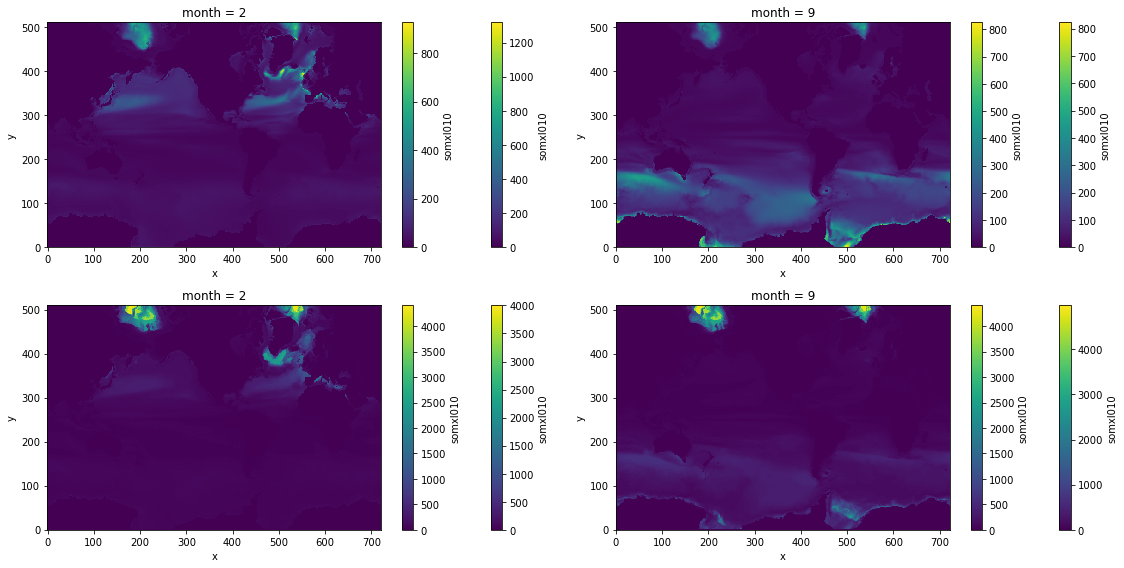

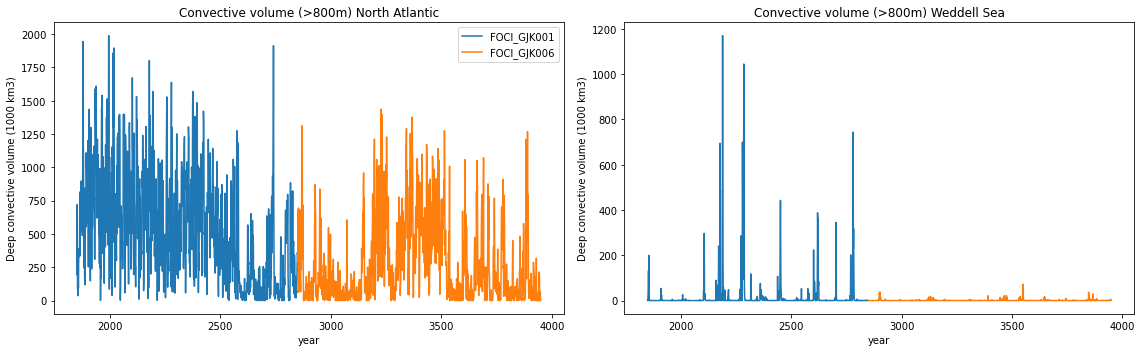

In [16]:
fig1, axs1 = plt.subplots(2,2,figsize=(16,8))
fig2, axs2 = plt.subplots(1,2,figsize=(16,5))

for i in range(0,len(exp_list)):
    ds_t = ds_t_1m[i]
    exp = exp_list[i]
    mld = ds_t['somxl010']
    
    mld_s = mld.groupby('time.month').mean('time')
    
    # Select Feb and Sep
    mld_s.sel(month=2).plot.pcolormesh(ax=axs1[0,0])
    mld_s.sel(month=9).plot.pcolormesh(ax=axs1[0,1])
    
    mld_s = mld.groupby('time.month').max('time')
    mld_s.sel(month=2).plot.pcolormesh(ax=axs1[1,0])
    mld_s.sel(month=9).plot.pcolormesh(ax=axs1[1,1])
    
    # Convective volume (annual mean)
    mld_mask = mld.where(mld > 800).groupby('time.year').mean('time')
    # North Atlantic
    mld_natl = mld_mask.sel(x=slice(450,550),y=slice(350,450)) * da_orca05_area.sel(x=slice(450,550),y=slice(350,450))
    mld_natl_vol = mld_natl.sum(('x','y')) * 1e-12
    mld_natl_vol.plot(ax=axs2[0],label=exp)
    # Weddell Sea
    mld_wed = mld_mask.sel(x=slice(480,600),y=slice(50,150)) * da_orca05_area.sel(x=slice(480,600),y=slice(50,150))
    mld_wed_vol = mld_wed.sum(('x','y')) * 1e-12
    mld_wed_vol.plot(ax=axs2[1],label=exp)
    
axs2[0].set_title('Convective volume (>800m) North Atlantic')
axs2[1].set_title('Convective volume (>800m) Weddell Sea')
axs2[0].legend()
for ax in axs2:
    ax.set_ylabel('Deep convective volume (1000 km3)')

fig1.tight_layout()
fig2.tight_layout()
#fig1.savefig('mld_mean_max.png',format='png',dpi=150)
fig2.savefig('plots/deep_conv_vol.pdf',format='pdf')

## Sea ice

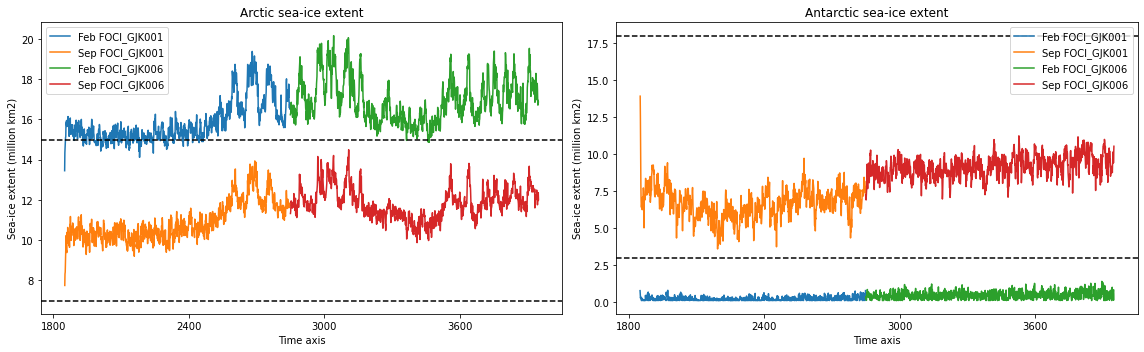

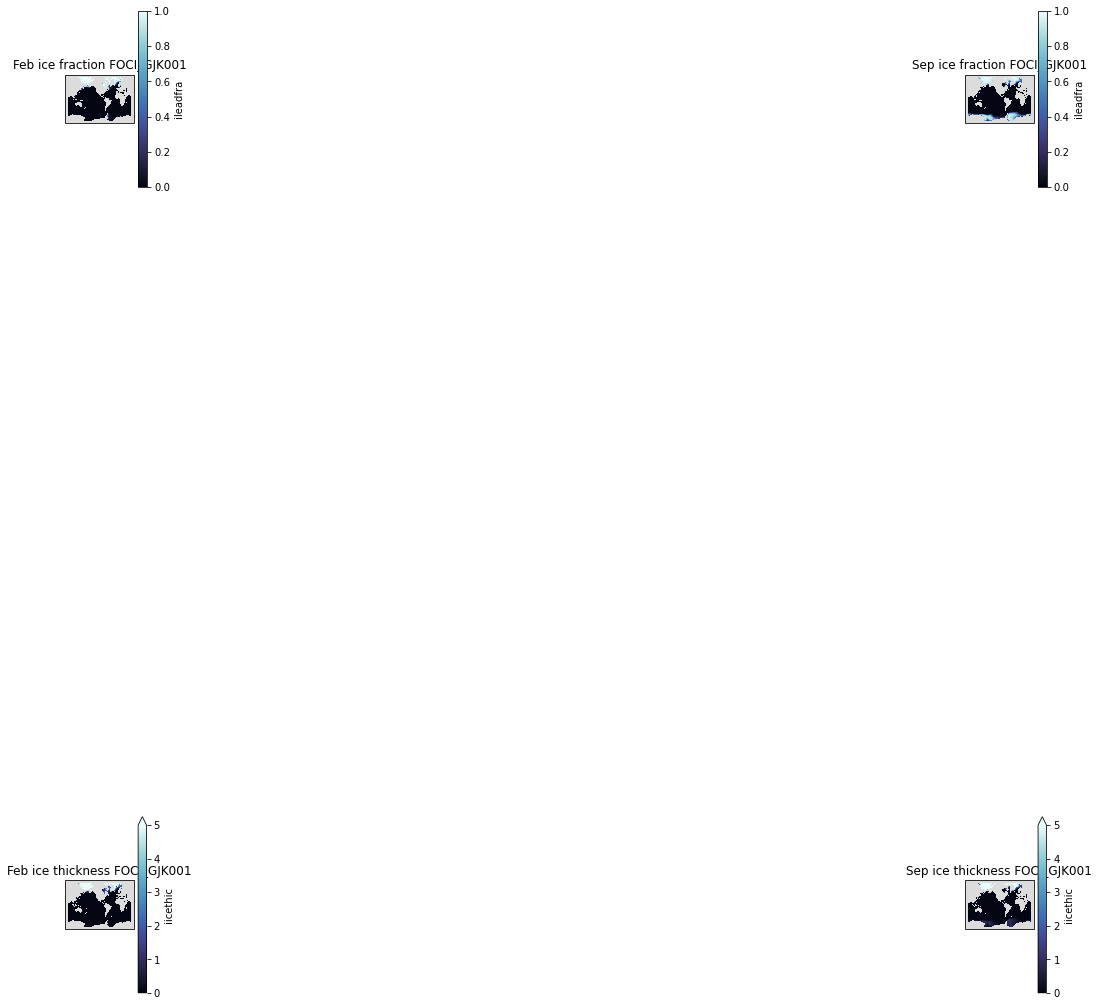

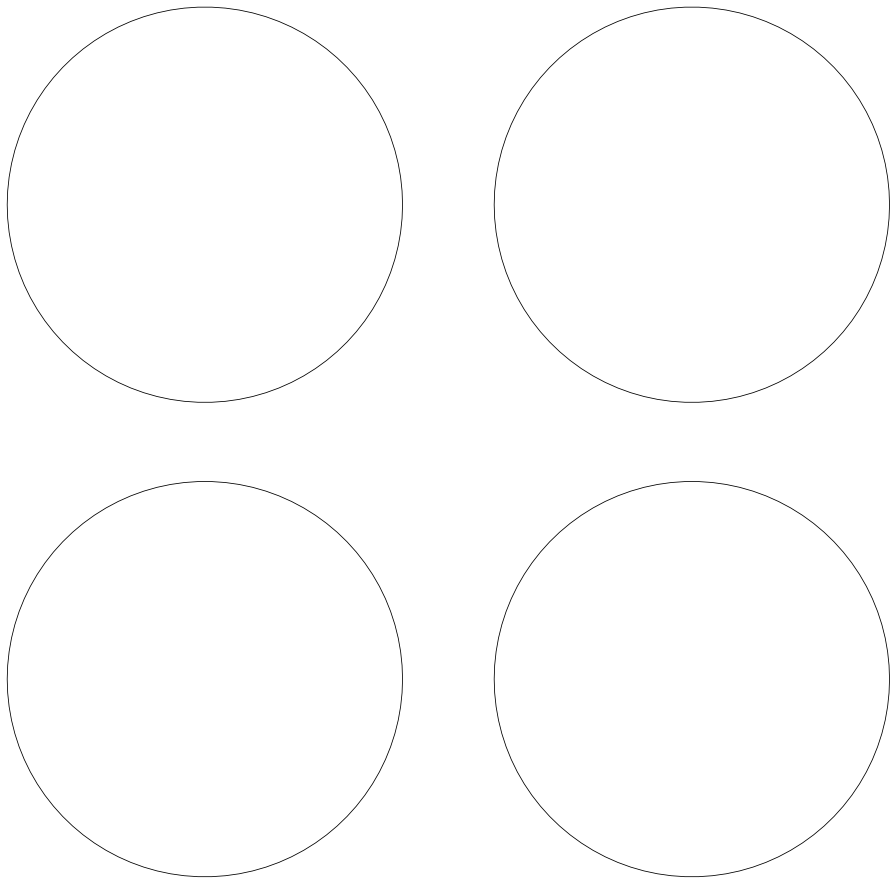

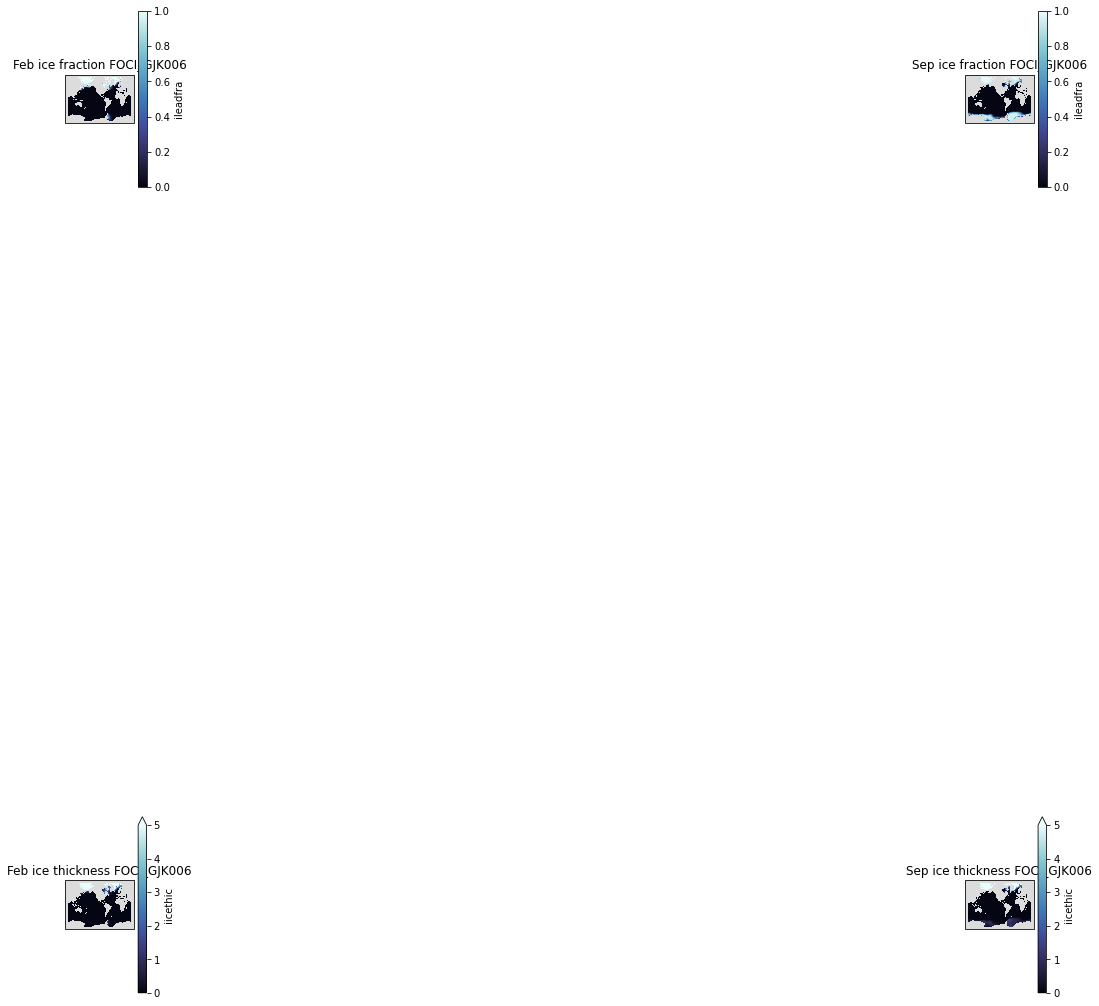

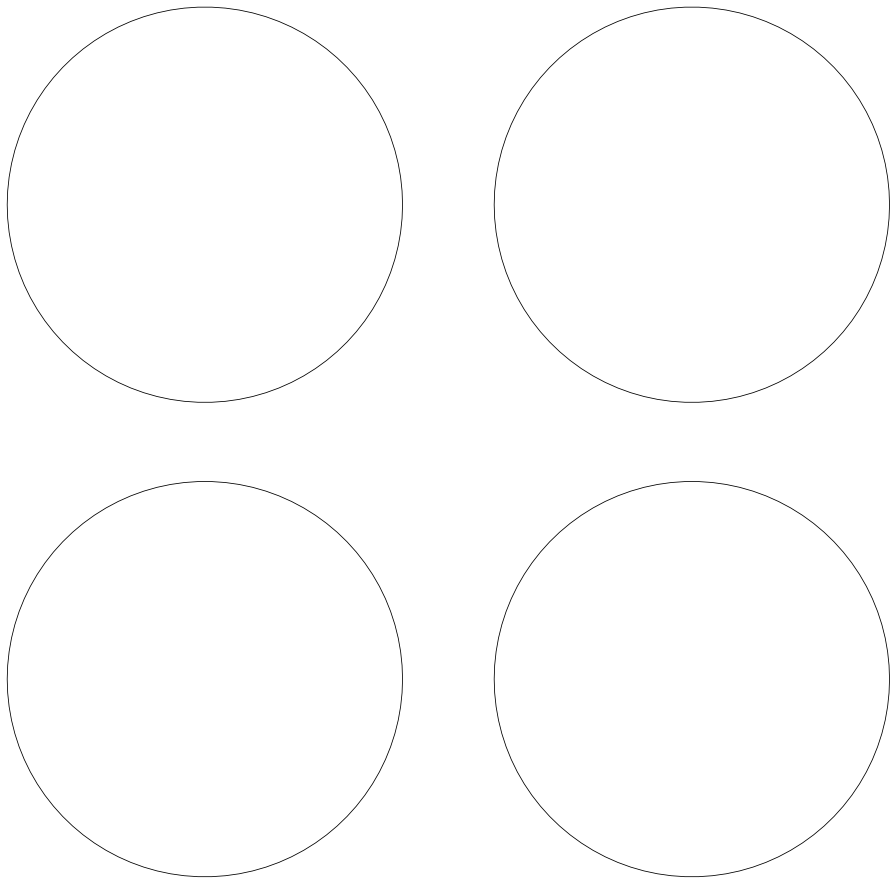

In [17]:
fig2, axs2 = plt.subplots(1,2,figsize=(16,5))

for i in range(0,len(exp_list)):
    ds_i = ds_i_all[i]
    exp = exp_list[i]
    
    # Ice fraction (0,1)
    icefrac = ds_i['ileadfra']
    # Ice thickness (m)
    icethk  = ds_i['iicethic']
    
    prj1 = ccrs.NorthPolarStereo()
    fig1, axs1 = plt.subplots(2,2,figsize=(16,16),subplot_kw={'projection':prj1})
    prj2 = ccrs.NorthPolarStereo()
    fig3, axs3 = plt.subplots(2,2,figsize=(16,16),subplot_kw={'projection':prj2})
    
    # Monthly averages where not land
    z = icefrac.groupby('time.month').mean('time').where(da_orca05_mask == 1)
    
    # Plot Feb and Sep
    z.sel(month=2).plot.pcolormesh(ax=axs1[0,0],vmin=0,vmax=1,cmap=cmocean.cm.ice)
    z.sel(month=9).plot.pcolormesh(ax=axs1[0,1],vmin=0,vmax=1,cmap=cmocean.cm.ice)
    axs1[0,0].set_title('Feb ice fraction %s' % (exp,))
    axs1[0,1].set_title('Sep ice fraction %s' % (exp,))
    
    # Monthly averages where not land
    z = icethk.groupby('time.month').mean('time').where(da_orca05_mask == 1)
    
    # Plot Feb and Sep
    z.sel(month=2).plot.pcolormesh(ax=axs1[1,0],vmin=0,vmax=5,cmap=cmocean.cm.ice)
    z.sel(month=9).plot.pcolormesh(ax=axs1[1,1],vmin=0,vmax=5,cmap=cmocean.cm.ice)
    axs1[1,0].set_title('Feb ice thickness %s' % (exp,))
    axs1[1,1].set_title('Sep ice thickness %s' % (exp,))
    
    for ax in axs1.flat:
        ax.set_facecolor('Gainsboro')
    
    fig1.tight_layout()
    fig1.savefig('ice_mean_%s.png' % (exp,),format='png',dpi=150)
    
    # Sea ice extent (where ice > 15 pcnt)
    ice_mask = icefrac.where(icefrac > 0.15)
    # Northern Hemisphere
    # Sea-ice area = SUM(fraction * area). 
    ice_nh = ice_mask.sel(y=slice(250,511)) * da_orca05_area.sel(y=slice(250,511))
    ice_nh_area = ice_nh.sum(('x','y')) * 1e-12 # scale to million km2
    ice_nh_area[1::12].plot(ax=axs2[0],label='Feb %s' % (exp,))
    ice_nh_area[8::12].plot(ax=axs2[0],label='Sep %s' % (exp,))
    # Southern Hemisphere 
    ice_sh = ice_mask.sel(y=slice(0,250)) * da_orca05_area.sel(y=slice(0,250))
    ice_sh_area = ice_sh.sum(('x','y')) * 1e-12
    ice_sh_area[1::12].plot(ax=axs2[1],label='Feb %s' % (exp,))
    ice_sh_area[8::12].plot(ax=axs2[1],label='Sep %s' % (exp,))
    
axs2[0].set_title('Arctic sea-ice extent')
axs2[1].set_title('Antarctic sea-ice extent')
    
axs2[0].axhline(y=7,linestyle='--',c='k')
axs2[0].axhline(y=15,linestyle='--',c='k')
axs2[1].axhline(y=3,linestyle='--',c='k')
axs2[1].axhline(y=18,linestyle='--',c='k')


for ax in axs2:
    ax.set_ylabel('Sea-ice extent (million km2)')
    ax.legend()
    
fig2.tight_layout()
fig2.savefig('ice_extent.pdf',format='pdf')

In [17]:
zz = z.compute()

In [ ]:
prj1 = ccrs.NorthPolarStereo()
prj2 = ccrs.SouthPolarStereo()
fig1 = plt.figure(figsize=(16,16))
axs1 = []
axs1.append( fig1.add_subplot(2,2,1,projection=prj1) )
axs1.append( fig1.add_subplot(2,2,2,projection=prj1) )
axs1.append( fig1.add_subplot(2,2,3,projection=prj2) )
axs1.append( fig1.add_subplot(2,2,4,projection=prj2) )
print(zz.where(zz!=np.nan))
zz.sel(month=2).plot.pcolormesh(ax=axs1[0],vmin=0,vmax=1,cmap=cmocean.cm.ice)
#zz.sel(month=9).plot.pcolormesh(ax=axs1[1],vmin=0,vmax=1,cmap=cmocean.cm.ice)
#zz.sel(month=2).plot.pcolormesh(ax=axs1[2],vmin=0,vmax=1,cmap=cmocean.cm.ice)
#zz.sel(month=9).plot.pcolormesh(ax=axs1[3],vmin=0,vmax=1,cmap=cmocean.cm.ice)
axs1[0].set_extent([-180, 180, 30, 90], ccrs.PlateCarree())
axs1[1].set_extent([-180, 180, 30, 90], ccrs.PlateCarree())
axs1[2].set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
axs1[3].set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
for ax in axs1:
    ax.coastlines()
fig1.tight_layout()

<xarray.DataArray 'iicethic' (month: 12, y: 511, x: 722)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, .

# Radiative budget

<xarray.DataArray (time: 1000, lat: 96, lon: 192)>
dask.array<mul, shape=(1000, 96, 192), dtype=float32, chunksize=(10, 96, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-07-01 06:00:00 ... 2849-07-01 06:00:00
  * lon      (lon) float32 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
  * lat      (lat) float32 -89.06 -87.19 -85.31 -83.44 ... 85.31 87.19 89.06
<xarray.DataArray (time: 70, lat: 96, lon: 192)>
dask.array<mul, shape=(70, 96, 192), dtype=float32, chunksize=(10, 96, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2850-07-01 06:00:00 ... 2919-07-01 06:00:00
  * lon      (lon) float32 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
  * lat      (lat) float32 -89.06 -87.19 -85.31 -83.44 ... 85.31 87.19 89.06


No handles with labels found to put in legend.


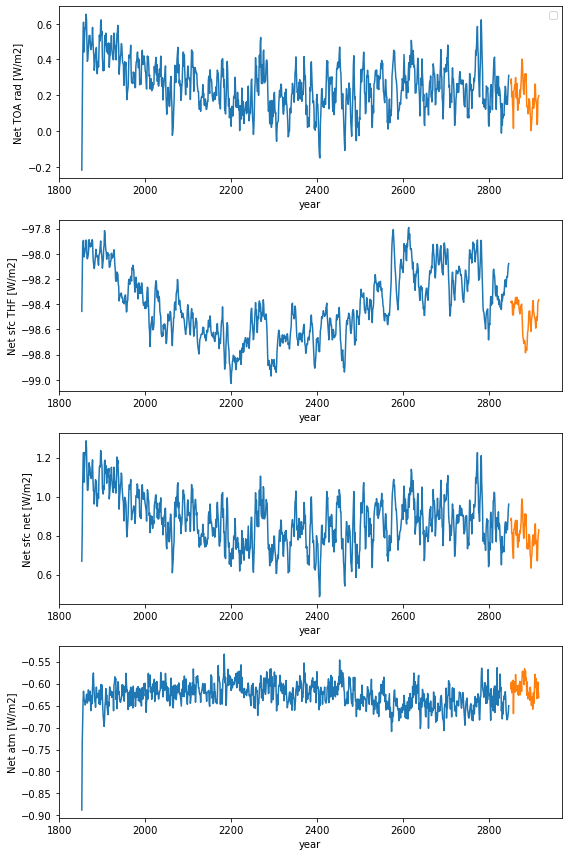

In [13]:
fscale = 1./(6 * 60 * 60.)

fig, ax = plt.subplots(4,1,figsize=(8,12))

for i in range(0,len(exp_list)):
    ds_sfc = ds_sfc_all[i]
    exp = exp_list[i]
    
    # This run had the wrong scaling
    if exp == 'foci-test-07':
        fscale = fscale * 2
    
    # Net TOA
    toa = (ds_sfc['tsr'] + ds_sfc['ttr']) * fscale
    print(toa)
    # Net turb sfc 
    thf = (ds_sfc['sshf'] + ds_sfc['slhf']) * fscale
    # Net sfc rad
    sfc = (ds_sfc['ssr'] + ds_sfc['str']) * fscale
    # Net atm (pos when warming)
    net = toa - thf - sfc 
    
    # Weighted global mean
    weights = np.cos(np.deg2rad(toa.lat))
    weights.name = "weights"
    
    toa_wgt = toa.weighted(weights)
    toa_mean = toa_wgt.mean(('lon','lat'))
    
    thf_wgt = thf.weighted(weights)
    thf_mean = thf_wgt.mean(('lon','lat'))
    
    sfc_wgt = sfc.weighted(weights)
    sfc_mean = sfc_wgt.mean(('lon','lat'))
    
    net_wgt = net.weighted(weights)
    net_mean = net_wgt.mean(('lon','lat'))
    
    # Annual mean
    toa = toa_mean.groupby('time.year').mean('time').rolling(year=5,center=True).mean()
    toa.plot(ax=ax[0],alpha=1)
    
    thf = thf_mean.groupby('time.year').mean('time').rolling(year=5,center=True).mean()
    thf.plot(ax=ax[1],alpha=1)
    
    sfc = sfc_mean.groupby('time.year').mean('time').rolling(year=5,center=True).mean()
    (sfc+thf).plot(ax=ax[2],alpha=1)
    
    net = net_mean.groupby('time.year').mean('time').rolling(year=5,center=True).mean()
    net.plot(ax=ax[3],alpha=1)
    
ax[0].legend()
ax[0].set_ylabel('Net TOA rad [W/m2]')
ax[1].set_ylabel('Net sfc THF [W/m2]')
ax[2].set_ylabel('Net sfc net [W/m2]')
ax[3].set_ylabel('Net atm [W/m2]')
fig.tight_layout()
fig.savefig('plots/radiation_equilibration.pdf',format='pdf')